### Importing the libraries


In [1]:
# Core Libraries
import os
import numpy as np  
import pandas as pd  

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset

import warnings
import joblib
warnings.filterwarnings("ignore")

In [2]:
cLabels = [
"NOSE_X", #0 
"NOSE_Y", #1
"NOSE_C", #2
    
"NECK_X", #3
"NECK_Y", #4
"NECK_C", #5
    
"R_SHOULDER_X", #6
"R_SHOULDER_Y", #7
"R_SHOULDER_C", #8
    
"R_ELBOW_X", #9
"R_ELBOW_Y", #10
"R_ELBOW_C", #11
    
"R_WRIST_X", #12
"R_WRIST_Y", #13
"R_WRIST_C", #14
    
"L_SHOULDER_X", #15
"L_SHOULDER_Y", #16
"L_SHOULDER_C", #17
    
"L_ELBOW_X", #18
"L_ELBOW_Y", #19
"L_ELBOW_C", #20
    
"L_WRIST_X", #21
"L_WRIST_Y", #22
"L_WRIST_C", #23
    
"M_HIP_X", #24
"M_HIP_Y", #25
"M_HIP_C", #26
    
"R_HIP_X", #27
"R_HIP_Y", #28
"R_HIP_C", #29
    
"R_KNEE_X", #30
"R_KNEE_Y", #31
"R_KNEE_C", #32
    
"R_ANKLE_X", #33
"R_ANKLE_Y", #34
"R_ANKLE_C", #35
    
"L_HIP_X", #36
"L_HIP_Y", #37
"L_HIP_C", #38
    
"L_KNEE_X", #39
"L_KNEE_Y", #40
"L_KNEE_C", #41
    
"L_ANKLE_X", #42
"L_ANKLE_Y", #43
"L_ANKLE_C", #44
    
"R_EYE_X", #45
"R_EYE_Y", #46
"R_EYE_C", #47
    
"L_EYE_X", #48
"L_EYE_Y", #49
"L_EYE_C", #50
    
"R_EAR_X", #51
"R_EAR_Y", #52
"R_EAR_C", #53
    
"L_EAR_X", #54
"L_EAR_Y", #55
"L_EAR_C", #56
    
"L_BIG_TOE_X", #57
"L_BIG_TOE_Y", #58
"L_BIG_TOE_C", #59
    
"L_SMALL_TOE_X", #60
"L_SMALL_TOE_Y", #61
"L_SMALL_TOE_C", #62
    
"L_HEEL_X", #63
"L_HEEL_Y", #64
"L_HEEL_C", #65
    
"R_BIG_TOE_X", #66
"R_BIG_TOE_Y", #67
"R_BIG_TOE_C", #68
    
"R_SMALL_TOE_X", #69
"R_SMALL_TOE_Y", #70
"R_SMALL_TOE_C", #71
    
"R_HEEL_X", #72
"R_HEEL_Y", #73
"R_HEEL_C", #74
    
"R_ANGLE_ELBOW", #75
"R_ANGLE_ARMPIT", #76
"L_ANGLE_ELBOW", #77
"L_ANGLE_ARMPIT", #78
]

activity_label = {
    "boxing": 0,
    "drums" : 1,
    "guitar" : 2,
    "rowing" : 3,
    "violin" : 4
}

In [3]:
selected_columns = ['NOSE_X', 'NOSE_Y', 'NECK_X', 'NECK_Y', 'R_SHOULDER_X', 'R_SHOULDER_Y',
           'R_ELBOW_X', 'R_ELBOW_Y', 'R_WRIST_X', 'R_WRIST_Y', 'L_SHOULDER_X',
           'L_SHOULDER_Y', 'L_ELBOW_X', 'L_ELBOW_Y', 'L_WRIST_X', 'L_WRIST_Y',
           'M_HIP_X', 'M_HIP_Y', 'R_HIP_X', 'R_HIP_Y']

### Preparing the Training and Testing set

In [4]:
def get_train_data(columns=None):
    train_path = '/kaggle/input/lsd-port-3/data/train'
    
    # lists for sequences and labels
    sequences = []
    labels = []
    
    files = [f for f in os.listdir(train_path) if f.endswith('.csv')]
    
    for file in files:
        file_path = os.path.join(train_path, file)
        present_df = pd.read_csv(file_path, header=None, names=cLabels, on_bad_lines='skip', na_values='?')
    
        start_idx = len(present_df) // 2
    
        present_df = present_df.iloc[start_idx:] 
        if columns is not None :
            present_df = present_df[columns]

        labels.append(file.split('_')[1])
    
        sequences.append(present_df.values)

    return sequences , labels


def get_test_data(columns=None):
    
    test_path = '/kaggle/input/lsd-port-3/data/test'
    
    test_sequences = []
    test_labels = []
    
    test_files = [f for f in os.listdir(test_path) if f.endswith('.csv')]
    
    for file in test_files:
        file_path = os.path.join(test_path, file)
        present_df = pd.read_csv(file_path, header=None, names=cLabels, on_bad_lines='skip', na_values='?')
    
        start_idx = len(present_df) // 2
    
        present_df = present_df.iloc[start_idx:]
        if columns is not None :
            present_df = present_df[columns]
    
        test_labels.append(file.split('_')[1])
    
        test_sequences.append(present_df.values)

    return test_sequences , test_labels

In [5]:
sequences , labels = get_train_data(columns=selected_columns)

max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length, dtype='float32', padding='post')

# Encode labels into numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Number of sequences: {len(sequences)}")
print(f"Number of unique labels: {len(label_encoder.classes_)}")
print(f"Shape of padded sequences: {sequences.shape}")

Number of sequences: 1167
Number of unique labels: 5
Shape of padded sequences: (1167, 945, 20)


## Random Forest 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(sequences, encoded_labels, test_size=0.2, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

y_pred_rf = rf_model.predict(X_test_flat)

print("rf_model  Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")


print('*'*30)

test_sequences , test_labels = get_test_data(columns = selected_columns) # columns = None - use None if do not want to use the selected features 

test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, dtype='float32', padding='post')

test_sequences_flat = test_sequences.reshape(test_sequences.shape[0], -1)

test_encoded_labels = label_encoder.transform(test_labels)

y_test_pred = rf_model.predict(test_sequences_flat)

print("Real Test Set Evaluation:")
print(classification_report(test_encoded_labels, y_test_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(test_encoded_labels, y_test_pred):.2f}")


rf_model  Classifier Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        48
           1       1.00      0.94      0.97        47
           2       0.96      0.96      0.96        47
           3       0.98      1.00      0.99        49
           4       1.00      0.98      0.99        43

    accuracy                           0.97       234
   macro avg       0.97      0.97      0.97       234
weighted avg       0.97      0.97      0.97       234

Accuracy: 0.97
******************************
Real Test Set Evaluation:
              precision    recall  f1-score   support

      boxing       0.42      0.68      0.52        60
       drums       1.00      0.37      0.54        62
      guitar       0.96      0.41      0.57        61
      rowing       0.94      1.00      0.97        61
      violin       0.49      0.75      0.60        61

    accuracy                           0.64       305
   macro avg       0.76      0

### SVM

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(sequences, encoded_labels, test_size=0.2, random_state=42)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

svm_model = SVC(kernel='rbf', random_state=42)  # Try different kernels: 'linear', 'poly', etc.
svm_model.fit(X_train_flat, y_train)

y_pred_svm = svm_model.predict(X_test_flat)

print("SVM Classifier Report:")
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")
print('*' * 30)

test_sequences, test_labels = get_test_data(columns=selected_columns)  # Use selected columns or None
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, dtype='float32', padding='post')
test_sequences_flat = test_sequences.reshape(test_sequences.shape[0], -1)

test_encoded_labels = label_encoder.transform(test_labels)

y_test_pred_svm = svm_model.predict(test_sequences_flat)
print("SVM - Real Test Set Evaluation:")
print(classification_report(test_encoded_labels, y_test_pred_svm, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(test_encoded_labels, y_test_pred_svm):.2f}")

SVM Classifier Report:
              precision    recall  f1-score   support

           0       0.55      0.73      0.62        48
           1       0.67      0.79      0.73        47
           2       0.90      0.55      0.68        47
           3       0.93      0.82      0.87        49
           4       0.70      0.70      0.70        43

    accuracy                           0.72       234
   macro avg       0.75      0.72      0.72       234
weighted avg       0.75      0.72      0.72       234

Accuracy: 0.72
******************************
SVM - Real Test Set Evaluation:
              precision    recall  f1-score   support

      boxing       0.39      0.60      0.47        60
       drums       0.65      0.45      0.53        62
      guitar       1.00      0.23      0.37        61
      rowing       0.94      0.95      0.94        61
      violin       0.46      0.70      0.55        61

    accuracy                           0.59       305
   macro avg       0.69      0

### XGBClassifier

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sequences, encoded_labels, test_size=0.2, random_state=42)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

xgb_model = XGBClassifier(n_estimators=100, random_state=42)

xgb_model.fit(X_train_flat, y_train)

y_pred_rf = xgb_model.predict(X_test_flat)

print("xgb  Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

print('*'*30)

test_sequences , test_labels = get_test_data(columns = selected_columns) # columns = None - use None if do not want to use the selected features

test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, dtype='float32', padding='post')

test_sequences_flat = test_sequences.reshape(test_sequences.shape[0], -1)

test_encoded_labels = label_encoder.transform(test_labels)

y_test_pred = xgb_model.predict(test_sequences_flat)

print("Real Test Set Evaluation:")
print(classification_report(test_encoded_labels, y_test_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(test_encoded_labels, y_test_pred):.2f}")


xgb  Classifier Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        48
           1       0.95      0.89      0.92        47
           2       0.94      0.94      0.94        47
           3       0.96      1.00      0.98        49
           4       0.98      0.95      0.96        43

    accuracy                           0.94       234
   macro avg       0.94      0.94      0.94       234
weighted avg       0.94      0.94      0.94       234

Accuracy: 0.94
******************************
Real Test Set Evaluation:
              precision    recall  f1-score   support

      boxing       0.57      0.83      0.68        60
       drums       0.97      0.55      0.70        62
      guitar       0.78      0.48      0.59        61
      rowing       0.91      1.00      0.95        61
      violin       0.57      0.74      0.64        61

    accuracy                           0.72       305
   macro avg       0.76      0.72  

### 1D CNN

In [9]:
sequences , labels = get_train_data(columns=selected_columns)

max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length, dtype='float32', padding='post')

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Number of sequences: {len(sequences)}")
print(f"Number of unique labels: {len(label_encoder.classes_)}")
print(f"Shape of padded sequences: {sequences.shape}")

class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

class CNN1DModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(256)

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(256 * (max_sequence_length // 2 // 2 // 2), num_classes)  # Adjust for sequence length after pooling

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, input_size, sequence_length)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc(x)
        return x

# Hyperparameters
input_size = 20  # Number of features - change this accordingly to how many features we have selected.
num_classes = 5  
batch_size = 12
learning_rate = 0.0001
num_epochs = 50
test_ratio = 0.2

dataset = SequenceDataset(sequences, encoded_labels)
test_size = int(len(dataset) * test_ratio)
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(12)
model = CNN1DModel(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_sequences, batch_labels in train_loader:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
        
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for batch_sequences, batch_labels in test_loader:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
        
        outputs = model(batch_sequences)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(batch_labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds))
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")


Number of sequences: 1167
Number of unique labels: 5
Shape of padded sequences: (1167, 945, 20)
Using device: cuda
Epoch [1/50], Loss: 0.7726
Epoch [2/50], Loss: 0.2035
Epoch [3/50], Loss: 0.1277
Epoch [4/50], Loss: 0.1585
Epoch [5/50], Loss: 0.1074
Epoch [6/50], Loss: 0.0515
Epoch [7/50], Loss: 0.0642
Epoch [8/50], Loss: 0.0405
Epoch [9/50], Loss: 0.0293
Epoch [10/50], Loss: 0.0233
Epoch [11/50], Loss: 0.0261
Epoch [12/50], Loss: 0.0171
Epoch [13/50], Loss: 0.0163
Epoch [14/50], Loss: 0.0250
Epoch [15/50], Loss: 0.0205
Epoch [16/50], Loss: 0.0152
Epoch [17/50], Loss: 0.0210
Epoch [18/50], Loss: 0.0608
Epoch [19/50], Loss: 0.0638
Epoch [20/50], Loss: 0.0333
Epoch [21/50], Loss: 0.0293
Epoch [22/50], Loss: 0.1185
Epoch [23/50], Loss: 0.0510
Epoch [24/50], Loss: 0.0546
Epoch [25/50], Loss: 0.0494
Epoch [26/50], Loss: 0.0901
Epoch [27/50], Loss: 0.0379
Epoch [28/50], Loss: 0.0338
Epoch [29/50], Loss: 0.0117
Epoch [30/50], Loss: 0.0133
Epoch [31/50], Loss: 0.0059
Epoch [32/50], Loss: 0.010

In [10]:
test_sequences , test_labels = get_test_data(columns = selected_columns) # columns = None - use None if do not want to use the selected features

test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, dtype='float32', padding='post')

test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_labels = label_encoder.transform(test_labels)
test_labels = torch.tensor(test_labels, dtype=torch.long)

test_dataset = SequenceDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for batch_sequences, batch_labels in test_loader:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
        
        # Forward pass
        outputs = model(batch_sequences)
        _, predicted = torch.max(outputs, 1)
        
        all_test_labels.extend(batch_labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

print("Test Set Evaluation:")
print(classification_report(all_test_labels, all_test_preds, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(all_test_labels, all_test_preds):.2f}")

Test Set Evaluation:
              precision    recall  f1-score   support

      boxing       0.57      0.90      0.70        60
       drums       0.87      0.73      0.79        62
      guitar       0.89      0.79      0.83        61
      rowing       0.94      0.98      0.96        61
      violin       0.88      0.59      0.71        61

    accuracy                           0.80       305
   macro avg       0.83      0.80      0.80       305
weighted avg       0.83      0.80      0.80       305

Accuracy: 0.80



Running with seed 1


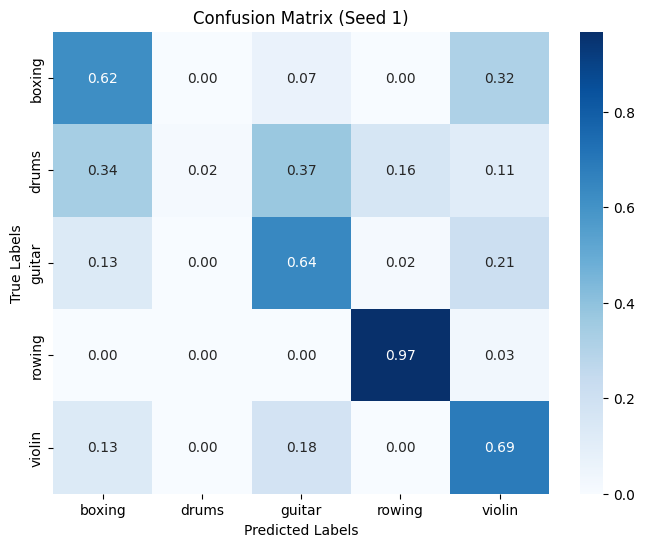


Running with seed 2


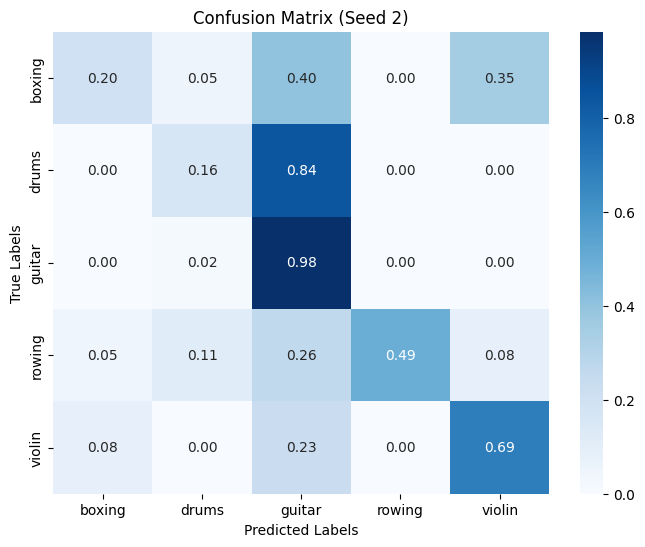


Running with seed 3


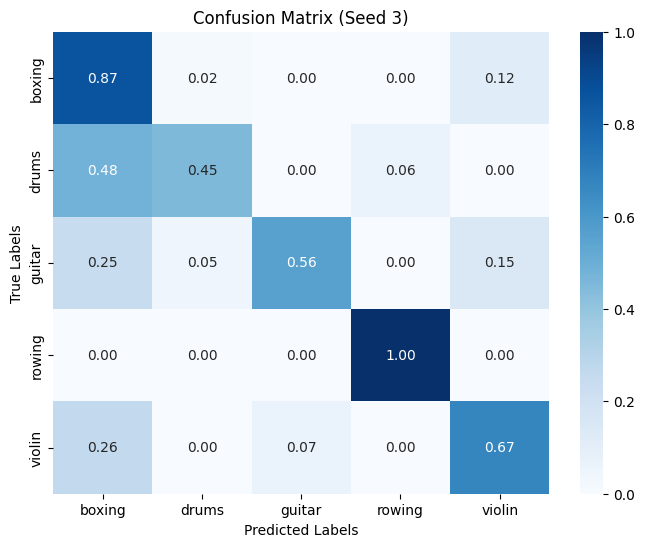


Running with seed 4


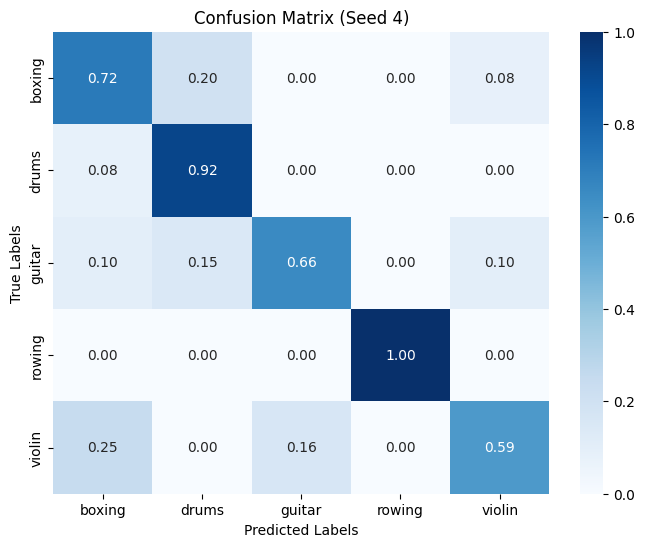


Running with seed 5


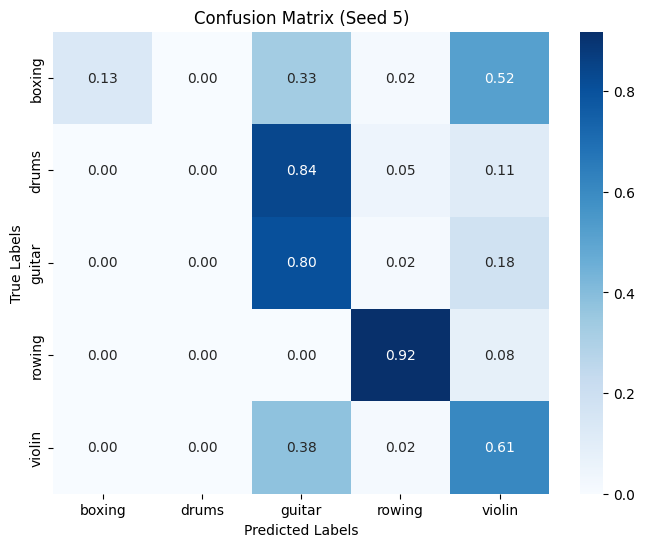

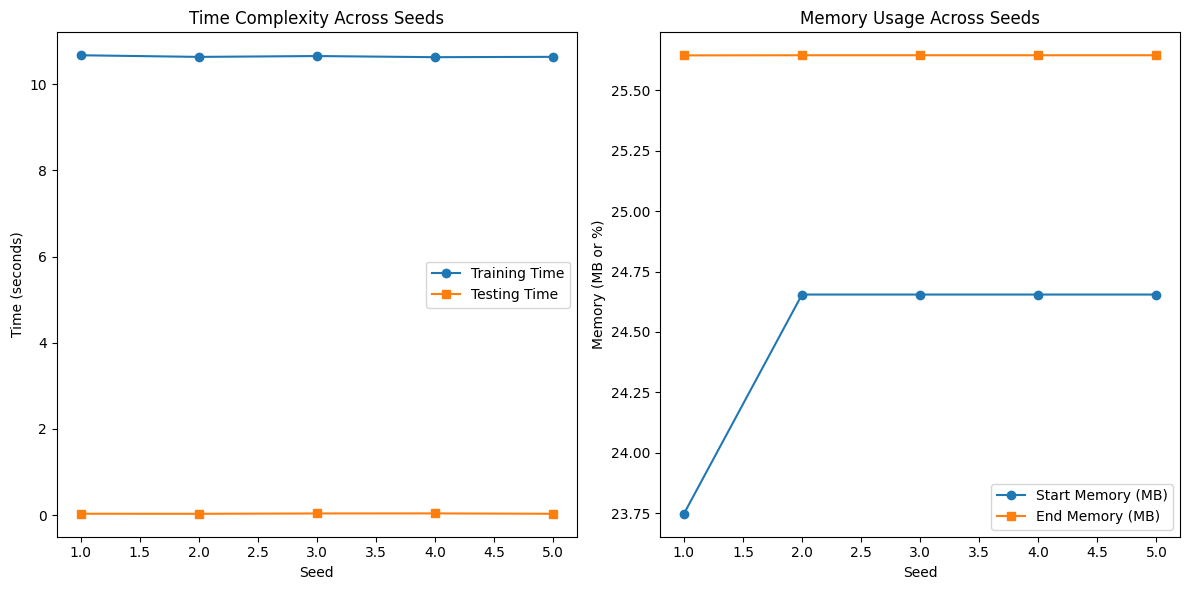

In [12]:
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_memory_usage():
    if torch.cuda.is_available():
        return {
            "allocated": torch.cuda.memory_allocated() / 1e6,  # MB
            "reserved": torch.cuda.memory_reserved() / 1e6,    # MB
        }
    else:
        memory_info = psutil.virtual_memory()
        return {"percent": memory_info.percent}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

for seed in [1, 2, 3, 4, 5]: 
    print(f"\nRunning with seed {seed}")
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Initialize model, criterion, optimizer, and loaders
    model = CNN1DModel(input_size, num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Record time and memory before training
    start_memory = get_memory_usage()
    start_time = time.time()

    # Training Loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        for batch_sequences, batch_labels in train_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Record time and memory after training
    training_time = time.time() - start_time
    end_memory = get_memory_usage()

    # Record testing time and calculate confusion matrix
    start_time = time.time()
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_sequences, batch_labels in test_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
            outputs = model(batch_sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    testing_time = time.time() - start_time

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize rows

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix (Seed {seed})")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Append results
    results.append({
        "seed": seed,
        "training_time": training_time,
        "testing_time": testing_time,
        "start_memory": start_memory,
        "end_memory": end_memory,
    })

# Visualize Results
training_times = [res["training_time"] for res in results]
testing_times = [res["testing_time"] for res in results]
seeds = [res["seed"] for res in results]

# Plot Training and Testing Time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(seeds, training_times, marker='o', label="Training Time")
plt.plot(seeds, testing_times, marker='s', label="Testing Time")
plt.xlabel("Seed")
plt.ylabel("Time (seconds)")
plt.title("Time Complexity Across Seeds")
plt.legend()

# Plot Memory Usage
start_memories = [res["start_memory"]["allocated"] if "allocated" in res["start_memory"] else res["start_memory"]["percent"] for res in results]
end_memories = [res["end_memory"]["allocated"] if "allocated" in res["end_memory"] else res["end_memory"]["percent"] for res in results]

plt.subplot(1, 2, 2)
plt.plot(seeds, start_memories, marker='o', label="Start Memory (MB)")
plt.plot(seeds, end_memories, marker='s', label="End Memory (MB)")
plt.xlabel("Seed")
plt.ylabel("Memory (MB or %)")
plt.title("Memory Usage Across Seeds")
plt.legend()

plt.tight_layout()
plt.show()


Running with sample size 100

Running with sample size 200

Running with sample size 300

Running with sample size 400

Running with sample size 500

Running with sample size 600

Running with sample size 700

Running with sample size 800


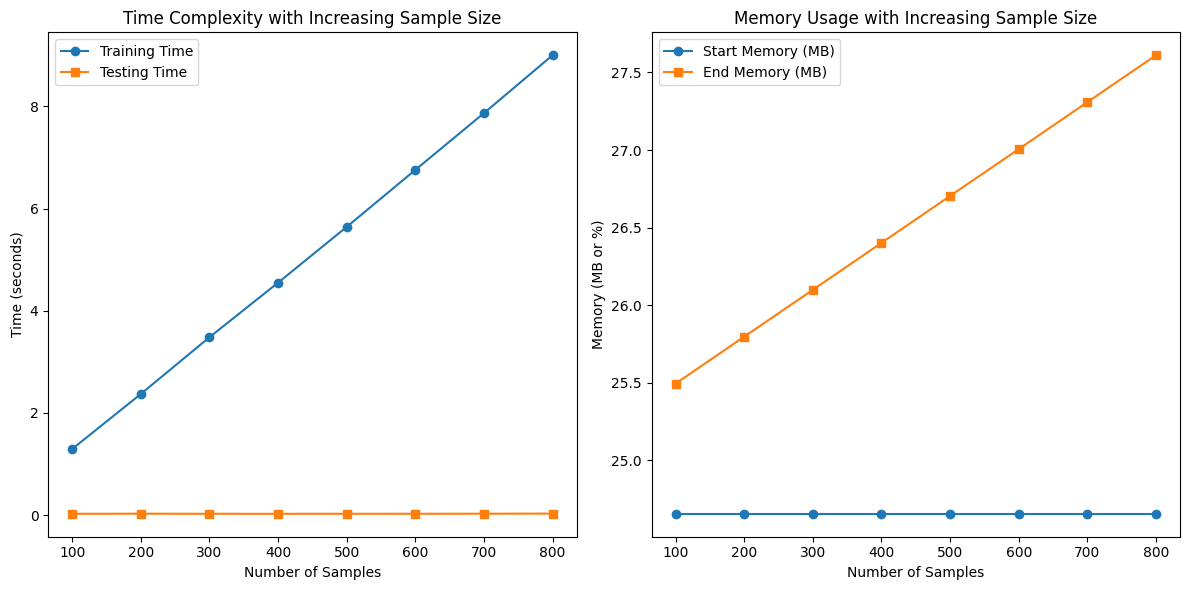

In [13]:
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from sklearn.metrics import confusion_matrix

# Function to track memory usage
def get_memory_usage():
    if torch.cuda.is_available():
        return {
            "allocated": torch.cuda.memory_allocated() / 1e6,  # MB
            "reserved": torch.cuda.memory_reserved() / 1e6,    # MB
        }
    else:
        memory_info = psutil.virtual_memory()
        return {"percent": memory_info.percent}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Placeholder for results
results = []

# Define sample sizes to test
sample_sizes = [100,200,300,400,500,600,700,800]  # Adjust based on your dataset
num_epochs = 50

for sample_size in sample_sizes:
    print(f"\nRunning with sample size {sample_size}")

    # Reduce dataset size (subset the training dataset)
    train_subset, _ = torch.utils.data.random_split(train_dataset, [sample_size, len(train_dataset) - sample_size])
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model, criterion, and optimizer
    model = CNN1DModel(input_size, num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Record time and memory before training
    start_memory = get_memory_usage()
    start_time = time.time()

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        for batch_sequences, batch_labels in train_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Record time and memory after training
    training_time = time.time() - start_time
    end_memory = get_memory_usage()

    # Record testing time
    start_time = time.time()
    model.eval()
    with torch.no_grad():
        for batch_sequences, batch_labels in test_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
            outputs = model(batch_sequences)
    testing_time = time.time() - start_time

    # Append results
    results.append({
        "sample_size": sample_size,
        "training_time": training_time,
        "testing_time": testing_time,
        "start_memory": start_memory,
        "end_memory": end_memory,
    })

# Visualize Results
sample_sizes = [res["sample_size"] for res in results]
training_times = [res["training_time"] for res in results]
testing_times = [res["testing_time"] for res in results]

# Plot Training and Testing Time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, training_times, marker='o', label="Training Time")
plt.plot(sample_sizes, testing_times, marker='s', label="Testing Time")
plt.xlabel("Number of Samples")
plt.ylabel("Time (seconds)")
plt.title("Time Complexity with Increasing Sample Size")
plt.legend()

# Plot Memory Usage
start_memories = [res["start_memory"]["allocated"] if "allocated" in res["start_memory"] else res["start_memory"]["percent"] for res in results]
end_memories = [res["end_memory"]["allocated"] if "allocated" in res["end_memory"] else res["end_memory"]["percent"] for res in results]

plt.subplot(1, 2, 2)
plt.plot(sample_sizes, start_memories, marker='o', label="Start Memory (MB)")
plt.plot(sample_sizes, end_memories, marker='s', label="End Memory (MB)")
plt.xlabel("Number of Samples")
plt.ylabel("Memory (MB or %)")
plt.title("Memory Usage with Increasing Sample Size")
plt.legend()

plt.tight_layout()
plt.show()

------------------------------------------------------------------------------------

### Training CNN for 5 times

Training Model with Seed 1...
Epoch [1/50], Loss: 0.7377
Epoch [2/50], Loss: 0.3002
Epoch [3/50], Loss: 0.1283
Epoch [4/50], Loss: 0.0745
Epoch [5/50], Loss: 0.0682
Epoch [6/50], Loss: 0.0410
Epoch [7/50], Loss: 0.0380
Epoch [8/50], Loss: 0.0278
Epoch [9/50], Loss: 0.0268
Epoch [10/50], Loss: 0.0454
Epoch [11/50], Loss: 0.0134
Epoch [12/50], Loss: 0.0093
Epoch [13/50], Loss: 0.0086
Epoch [14/50], Loss: 0.0065
Epoch [15/50], Loss: 0.0058
Epoch [16/50], Loss: 0.0046
Epoch [17/50], Loss: 0.0143
Epoch [18/50], Loss: 0.0456
Epoch [19/50], Loss: 0.0180
Epoch [20/50], Loss: 0.0321
Epoch [21/50], Loss: 0.0385
Epoch [22/50], Loss: 0.0519
Epoch [23/50], Loss: 0.1365
Epoch [24/50], Loss: 0.0325
Epoch [25/50], Loss: 0.0289
Epoch [26/50], Loss: 0.0163
Epoch [27/50], Loss: 0.0223
Epoch [28/50], Loss: 0.0233
Epoch [29/50], Loss: 0.0050
Epoch [30/50], Loss: 0.0016
Epoch [31/50], Loss: 0.0013
Epoch [32/50], Loss: 0.0028
Epoch [33/50], Loss: 0.0085
Epoch [34/50], Loss: 0.0222
Epoch [35/50], Loss: 0.0050

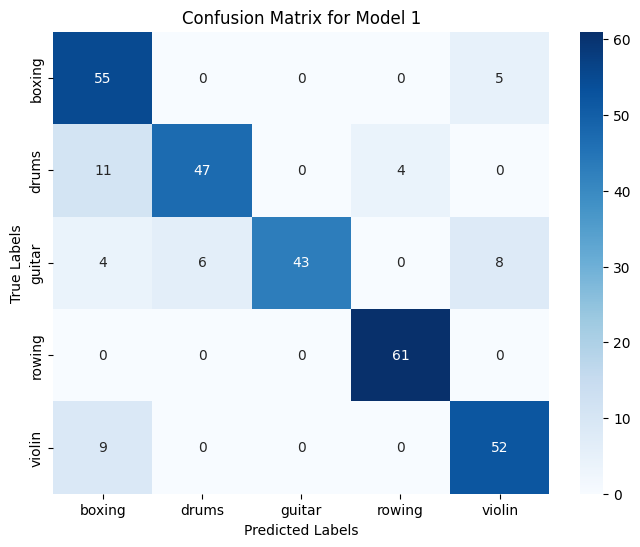

Training Model with Seed 2...
Epoch [1/50], Loss: 0.7330
Epoch [2/50], Loss: 0.2751
Epoch [3/50], Loss: 0.1286
Epoch [4/50], Loss: 0.1208
Epoch [5/50], Loss: 0.0545
Epoch [6/50], Loss: 0.0698
Epoch [7/50], Loss: 0.0462
Epoch [8/50], Loss: 0.0511
Epoch [9/50], Loss: 0.0326
Epoch [10/50], Loss: 0.0309
Epoch [11/50], Loss: 0.0230
Epoch [12/50], Loss: 0.0288
Epoch [13/50], Loss: 0.0088
Epoch [14/50], Loss: 0.0053
Epoch [15/50], Loss: 0.0336
Epoch [16/50], Loss: 0.0693
Epoch [17/50], Loss: 0.0194
Epoch [18/50], Loss: 0.0459
Epoch [19/50], Loss: 0.0511
Epoch [20/50], Loss: 0.0202
Epoch [21/50], Loss: 0.0115
Epoch [22/50], Loss: 0.0109
Epoch [23/50], Loss: 0.0104
Epoch [24/50], Loss: 0.0110
Epoch [25/50], Loss: 0.0124
Epoch [26/50], Loss: 0.0062
Epoch [27/50], Loss: 0.0200
Epoch [28/50], Loss: 0.0057
Epoch [29/50], Loss: 0.0029
Epoch [30/50], Loss: 0.0319
Epoch [31/50], Loss: 0.0378
Epoch [32/50], Loss: 0.0439
Epoch [33/50], Loss: 0.0575
Epoch [34/50], Loss: 0.0251
Epoch [35/50], Loss: 0.0717

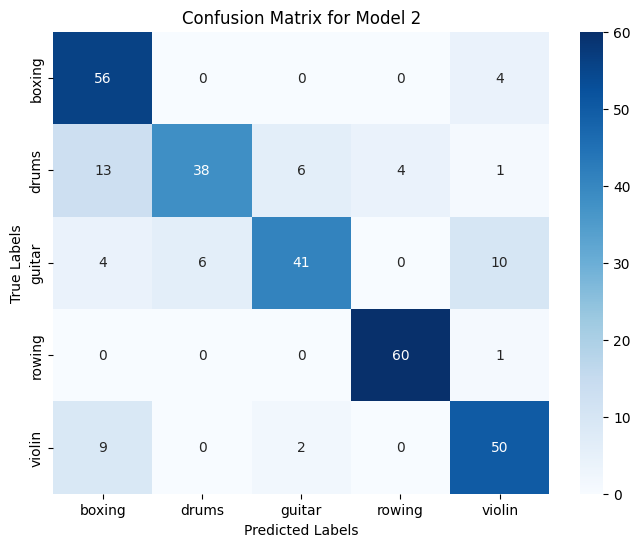

Training Model with Seed 3...
Epoch [1/50], Loss: 0.6770
Epoch [2/50], Loss: 0.2611
Epoch [3/50], Loss: 0.1220
Epoch [4/50], Loss: 0.1101
Epoch [5/50], Loss: 0.0798
Epoch [6/50], Loss: 0.0400
Epoch [7/50], Loss: 0.0590
Epoch [8/50], Loss: 0.0808
Epoch [9/50], Loss: 0.0684
Epoch [10/50], Loss: 0.0262
Epoch [11/50], Loss: 0.0104
Epoch [12/50], Loss: 0.0179
Epoch [13/50], Loss: 0.0277
Epoch [14/50], Loss: 0.0161
Epoch [15/50], Loss: 0.0180
Epoch [16/50], Loss: 0.0130
Epoch [17/50], Loss: 0.0118
Epoch [18/50], Loss: 0.0256
Epoch [19/50], Loss: 0.0091
Epoch [20/50], Loss: 0.0033
Epoch [21/50], Loss: 0.0023
Epoch [22/50], Loss: 0.0028
Epoch [23/50], Loss: 0.0286
Epoch [24/50], Loss: 0.0149
Epoch [25/50], Loss: 0.0048
Epoch [26/50], Loss: 0.0039
Epoch [27/50], Loss: 0.0045
Epoch [28/50], Loss: 0.0025
Epoch [29/50], Loss: 0.0068
Epoch [30/50], Loss: 0.0017
Epoch [31/50], Loss: 0.0017
Epoch [32/50], Loss: 0.0015
Epoch [33/50], Loss: 0.0012
Epoch [34/50], Loss: 0.0009
Epoch [35/50], Loss: 0.0013

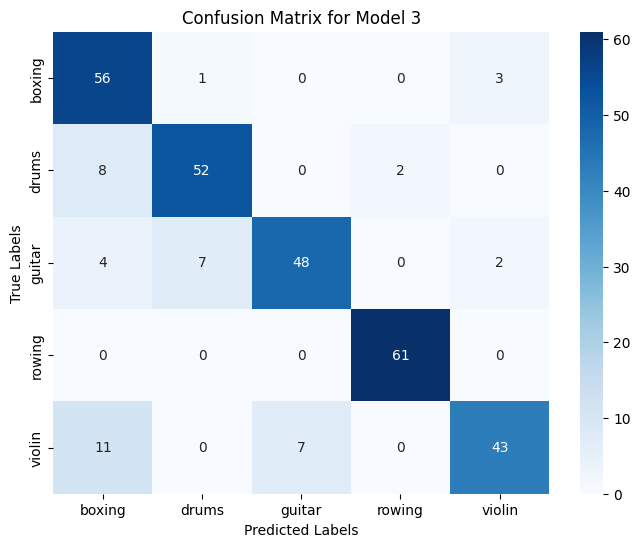

Training Model with Seed 4...
Epoch [1/50], Loss: 0.7234
Epoch [2/50], Loss: 0.2423
Epoch [3/50], Loss: 0.1085
Epoch [4/50], Loss: 0.1045
Epoch [5/50], Loss: 0.0701
Epoch [6/50], Loss: 0.0937
Epoch [7/50], Loss: 0.0405
Epoch [8/50], Loss: 0.0382
Epoch [9/50], Loss: 0.0325
Epoch [10/50], Loss: 0.0460
Epoch [11/50], Loss: 0.0374
Epoch [12/50], Loss: 0.0790
Epoch [13/50], Loss: 0.0350
Epoch [14/50], Loss: 0.0087
Epoch [15/50], Loss: 0.0112
Epoch [16/50], Loss: 0.1024
Epoch [17/50], Loss: 0.0603
Epoch [18/50], Loss: 0.0134
Epoch [19/50], Loss: 0.0123
Epoch [20/50], Loss: 0.0046
Epoch [21/50], Loss: 0.0023
Epoch [22/50], Loss: 0.0059
Epoch [23/50], Loss: 0.0117
Epoch [24/50], Loss: 0.0040
Epoch [25/50], Loss: 0.0012
Epoch [26/50], Loss: 0.0015
Epoch [27/50], Loss: 0.0012
Epoch [28/50], Loss: 0.0010
Epoch [29/50], Loss: 0.0015
Epoch [30/50], Loss: 0.0008
Epoch [31/50], Loss: 0.0007
Epoch [32/50], Loss: 0.0009
Epoch [33/50], Loss: 0.0008
Epoch [34/50], Loss: 0.0007
Epoch [35/50], Loss: 0.0007

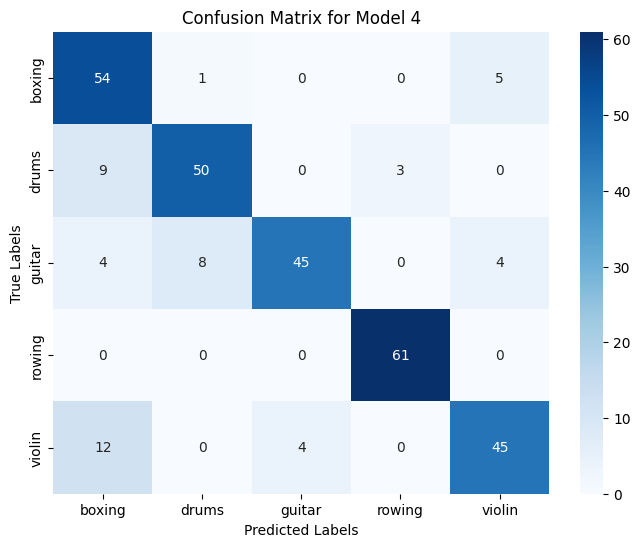

Training Model with Seed 5...
Epoch [1/50], Loss: 0.6602
Epoch [2/50], Loss: 0.1895
Epoch [3/50], Loss: 0.1335
Epoch [4/50], Loss: 0.1101
Epoch [5/50], Loss: 0.0519
Epoch [6/50], Loss: 0.0402
Epoch [7/50], Loss: 0.0660
Epoch [8/50], Loss: 0.0437
Epoch [9/50], Loss: 0.0264
Epoch [10/50], Loss: 0.0610
Epoch [11/50], Loss: 0.1016
Epoch [12/50], Loss: 0.0887
Epoch [13/50], Loss: 0.0297
Epoch [14/50], Loss: 0.0178
Epoch [15/50], Loss: 0.0053
Epoch [16/50], Loss: 0.0233
Epoch [17/50], Loss: 0.0038
Epoch [18/50], Loss: 0.0107
Epoch [19/50], Loss: 0.0184
Epoch [20/50], Loss: 0.0146
Epoch [21/50], Loss: 0.0221
Epoch [22/50], Loss: 0.0223
Epoch [23/50], Loss: 0.0142
Epoch [24/50], Loss: 0.0200
Epoch [25/50], Loss: 0.0296
Epoch [26/50], Loss: 0.0438
Epoch [27/50], Loss: 0.0183
Epoch [28/50], Loss: 0.0067
Epoch [29/50], Loss: 0.0065
Epoch [30/50], Loss: 0.0019
Epoch [31/50], Loss: 0.0018
Epoch [32/50], Loss: 0.0068
Epoch [33/50], Loss: 0.0029
Epoch [34/50], Loss: 0.0046
Epoch [35/50], Loss: 0.0027

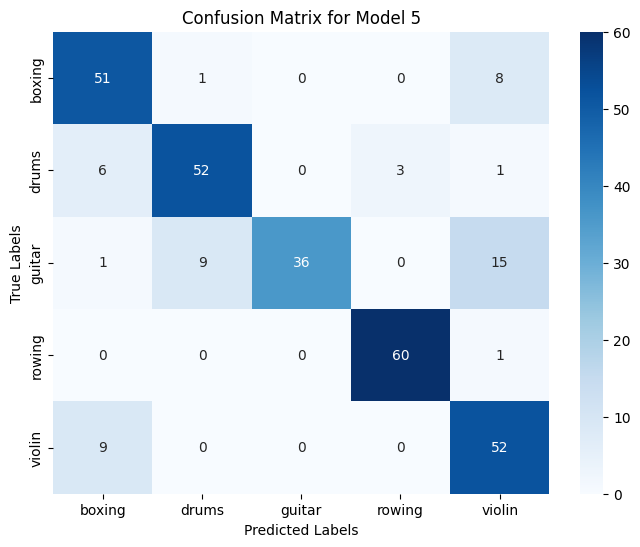

Model 1 Test Accuracy: 0.8459
Model 2 Test Accuracy: 0.8033
Model 3 Test Accuracy: 0.8525
Model 4 Test Accuracy: 0.8361
Model 5 Test Accuracy: 0.8230


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import pandas as pd

# Function to get train data
def get_train_data(columns=None):
    train_path = '/kaggle/input/lsd-port-3/data/train'
    sequences = []
    labels = []

    files = [f for f in os.listdir(train_path) if f.endswith('.csv')]

    for file in files:
        file_path = os.path.join(train_path, file)
        present_df = pd.read_csv(file_path, header=None, names=cLabels, on_bad_lines='skip', na_values='?')

        start_idx = len(present_df) // 2
        present_df = present_df.iloc[start_idx:]
        
        if columns is not None:
            present_df = present_df[columns]
        
        labels.append(file.split('_')[1])  # Extract label from file name
        sequences.append(present_df.values)

    return sequences, labels

# Prepare the dataset and labels
sequences, labels = get_train_data(columns=selected_columns)

# Ensure all sequences are of equal length (pad shorter ones)
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length, dtype='float32', padding='post')

# Encode labels into numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Define dataset class
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Define 1D CNN model
class CNN1DModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(256)

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(256 * (max_sequence_length // 2 // 2 // 2), num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, input_size, sequence_length)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc(x)
        return x

# Prepare the dataset and dataloaders
dataset = SequenceDataset(sequences, encoded_labels)
test_size = int(len(dataset) * 0.2)
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)

# Prepare to evaluate for multiple seeds
accuracies = []

# Test set data preparation
test_sequences, test_labels = get_test_data(columns=selected_columns)
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, dtype='float32', padding='post')
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_labels = label_encoder.transform(test_labels)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create test dataset and dataloader
test_dataset = SequenceDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)

# Loop to train and evaluate the model for 5 different random seeds
for seed in range(5):
    print(f"Training Model with Seed {seed + 1}...")  # Print current run number
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Initialize the model
    model = CNN1DModel(input_size=20, num_classes=len(label_encoder.classes_)).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(50):
        model.train()
        total_loss = 0
        for batch_sequences, batch_labels in train_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

            # Forward pass
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/50], Loss: {total_loss / len(train_loader):.4f}")

    # Testing loop
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_sequences, batch_labels in test_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

            outputs = model(batch_sequences)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(batch_labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Evaluate on the current model
    print("Classification Report for Model {}:".format(seed + 1))
    print(classification_report(all_labels, all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    accuracies.append(accuracy)
    print(f"Accuracy for Model {seed + 1}: {accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix for Model {seed + 1}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Final evaluation on the real test set
for i, accuracy in enumerate(accuracies):
    print(f"Model {i + 1} Test Accuracy: {accuracy:.4f}")

# For the real test set predictions, you can choose the best model and do further evaluations


In [15]:
print(f'Std of CNN Model 5 Runs : {np.round(np.std(accuracies),2)}')
print(f'Mean of CNN Model 5 Runs : {np.round(np.mean(accuracies),2)}')

Std of CNN Model 5 Runs : 0.02
Mean of CNN Model 5 Runs : 0.83
